# Générer du texte avec des RNN

Nous utiliserons pour cela un module adapté par Donald Dong qui permet d'entraîner rapidement un RNN pour la génération de texte, appelé `rnn-text-gen`. La documentation autour du module en question est [disponible sur Github](https://github.com/donaldong/rnn-text-gen).

Contrairement au module `markovify`, nous n'allons pas installer le module et l'importer comme n'importe quel module Python. Nous allons ici devoir récupérer le répertoire git et l'importer ici.

On commence pour cela par cloner le répertoire Git.

In [9]:
!git clone https://github.com/donaldong/rnn-text-gen.git

fatal: destination path 'rnn-text-gen' already exists and is not an empty directory.


On remplace le fichier `text_generator.py` par celui disponible sur iCampus. 

Ce nouveau code est une migration de l'ancien code de Tensorflow 1 à Tensorflow 2, incluant la modification de certaines fonctions. Il inclut en outre en introduction la fonction `tf.compat.v1.disable_v2_behavior()` qui neutralise les derniers comportements indésirables.

L'utilisation de ce code entraîne encore des avertissements, certaines fonctions devenant obsolètes, mais ces avertissements ne sont pas en l'état rédhibitoire.

Il nous faut alors dire au système (ici, notre système virtuel) où se trouve le module que l'on a récupé. On le fait à l'aide du code dans la cellule suivante.

In [20]:
import sys
sys.path.insert(0,'/Documents/WikiFandomGen/scripts/rnn-text-gen')

Le module repose sur une version de TensorFlow antérieure à celle actuellement supportée par Google Colaboratory. Pour pouvoir faire tourner le module en l'état sans devoir en adapter le code pour le rendre compatible avec la version la plus récente de TensorFlow, on installe sur notre instance virtuelle la bonne version de TensorFlow.

Il nous faut maintenant importer les classes et libraires pertinentes

In [21]:
# On importe les classes issues du module custom que nous avons cloné
from src/text_generator import RNNTextGenerator
from src/dataset import Dataset

# On importe les librairies classiques nécessaires pour la suite
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'src'

On peut alors commencer à entraîner notre RNN.

On commence par charger notre corpus d'entraînement. Ici, le module vient avec quelques corpus, dont on peut regarder rapidement à quoi ils ressemblent.

In [3]:
f = open('/path/to/rnn-text-gen/data/alice.txt')
text = f.read()
print(text[:400])

ALICE'S ADVENTURES IN WONDERLAND

Lewis Carroll

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversations in
it, 'and what is the use of a book,' thought Alice 'without pictures or
conversations?'

So she was co


Il nous faut maintenant définir les paramètres d'entraînement. Parmi ces paramètres, on trouve :
- La taille des batchs (batch_size)
- La longueur des séquences (seq_length)
- Le nombre d'époch (epoch)
- Le taux d'apprentissage (learning_rate)

In [4]:
seq_length = 25
learning_rate = 0.01
epoch = 1
batch_size = 25

On peut alors traiter le corpus, c'est-à-dire créer les vecteurs qui serviront d'input au RNN. Le présent module propose par la fonction Dataset de transformer le corpus en un ensemble de batchs comprenant *n* séquences de longueur *j* de vecteurs one-hot (où *n* correspond à la valeur définie par batch_size, et *j* à la longueur des séquences définie par seq_length)

Notons qu'ici, la fonction crée des vecteurs pour les caractères, mais on peut de façon générale choisir de faire des vecteurs pour les mots eux-mêmes et non les caractères.

De même, les RNNs peuvent prendre en entrée des vecteurs de type *word embeddings*, mais nous nous limiterons ici aux vecteurs one-hot.


In [5]:
alice_dataset = Dataset(['/path/to/rnn-text-gen/data/alice.txt'], seq_length)

On peut alors entraîner le modèle à l'aide de la fonction `RNNTextGenerator()`. Un argument important de cette fonction est le type d'unités que l'on utilise (ici BasicRNNCell). On pourra plus tard utiliser des unités de type LSTM ou GRU pour entraîner les réseaux de neurones correspondants.

In [6]:
rnn_model = RNNTextGenerator(
    seq_length,
    alice_dataset.vocab_size,
    rnn_cell=tf.compat.v1.nn.rnn_cell.BasicRNNCell,
    learning_rate=learning_rate,
    epoch=epoch,
    batch_size=batch_size,
)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2022-12-14 08:31:31.639494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-14 08:31:31.639767: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 08:31:31.639800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Asclepios): /proc/driver/nvidia/version does not exist
2022-12-14 08:31:31.641308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/mwauquier/Enseignement/2022-2023/LYSL001-Machine

Une façon d'évaluer nos paramètres et le degré de convergence de notre RNN consiste à voir comment évoluent la précision (Accuracy) et la fonction objectif (loss function).

On commence par faire converger le modèle sur nos données, et on sauvegarde les scores dans une variable.

In [7]:
rnn_model_scores = rnn_model.fit(
    alice_dataset,
    save_scores=True
)

On peut alors produire une visualisation graphique de l'évolution de ces scores.

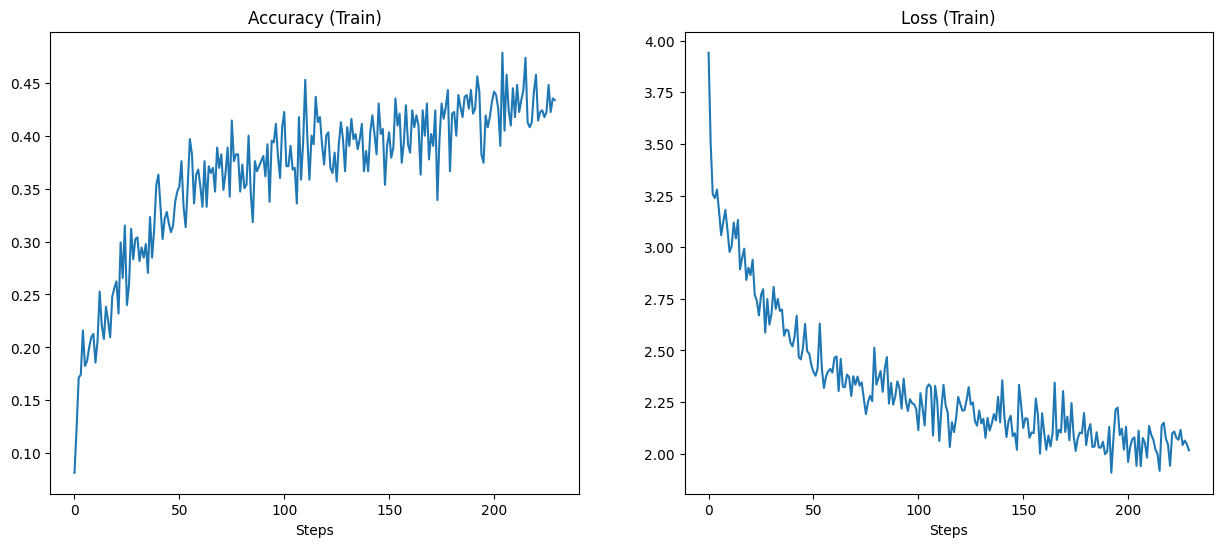

In [8]:
fig, axes = plt.subplots(figsize=(15, 6), ncols=2)
rnn_model_scores['accuracy'].plot(
    ax=axes[0], title='Accuracy (Train)'
)
rnn_model_scores['loss'].plot(
    ax=axes[1], title='Loss (Train)'
)
for ax in axes:
    ax.set(xlabel='Steps')

La courbe de la fonction objectif doit normalement une courbe descendante d'abord rapide puis qui ralentit. Si la courbe ne se stabilise cependant pas (qu'il y a beaucoup de pics par exemple), on considère que le RNN n'a pas convergé. Un modèle ne converge pas quand la fonction objectif ne se stabilise pas. Une raison à cette non-convergence peut s'expliquer par le nombre limité d'epochs (1) que nous avons fixé. On peut donc choisir de réentraîner notre RNN avec un nombre d'epochs plus élevé, par exemple.

Sachez que l'on peut aussi affiner notre modèle sans le réentraîner de 0 en le va le 'fit' sur nos données (on peut considérer cela comme un epoch). On peut ainsi demander au modèle de s'affiner un certain nombre de fois, ou durant une certaine période, comme on le fait ci-dessous.

De façon assez intéressante, on peut suivre l'évolution en direct de ces scores et de l'état de la prédiction en temps réel à mesure que le RNN s'entraîne.

In [9]:
# On importe la fonction native du module permettant de fixer une durée maximale à l'entraînement
from src.time_limit import time_limit

# On définit la durée de l'entraînement
for _ in time_limit(seconds=60): 
  # On affine le modèle
    rnn_model.fit(alice_dataset)
    acc, loss = rnn_model.score(alice_dataset)
  # On imprime à chaque epoch la précision et la valeur de la loss function
    print('test acc: {}, test loss: {}'.format(
        acc, loss
    ))
  # On demande à chaque epoch d'imprimer une séquence de 100 caractères prédits à partir de la séquence initiale 'Yes, but '
    start_seq = 'Yes, but '
    print(start_seq + rnn_model.generate(
        alice_dataset,
        start_seq,
        100
    ))
    print('-----------------------')

test acc: 0.4585599899291992, test loss: 1.9288740158081055
INFO:tensorflow:Restoring parameters from ./model/RNNTextGenerator
Yes, but sorupear t it, wond: Sor waslle sousct.'

'How ffolllitish the Dony,  tlight hismm tyout ort,' said 
-----------------------
test acc: 0.47968000173568726, test loss: 1.80149245262146
INFO:tensorflow:Restoring parameters from ./model/RNNTextGenerator
Yes, but she look,' said the dorsen to sippinise foinll was deall was to
grebshes, the King, as frow a said h
-----------------------
test acc: 0.48767995834350586, test loss: 1.8074411153793335
INFO:tensorflow:Restoring parameters from ./model/RNNTextGenerator
Yes, but ooghentioule!' she
croom, "n tichiw. 'I voice: 'torsaw whily.

PTERr.

'Come of Lover which a, about
-----------------------
test acc: 0.48639997839927673, test loss: 1.7882955074310303
INFO:tensorflow:Restoring parameters from ./model/RNNTextGenerator
Yes, but low.'

here Kind well, she was peem
eave door hande that
she shame it wes ane
yo

Yes, but its beak to her far Mirn the Hatter, it would soepouphing Hare off
at makting, the
book oft
take as 
-----------------------
test acc: 0.5507199764251709, test loss: 1.5409507751464844
INFO:tensorflow:Restoring parameters from ./model/RNNTextGenerator
Yes, but ol oor and stay all that, 'Wown's shorruphed
at thing, play--"Big the darchilt, and mak--'

'I MISER
-----------------------
test acc: 0.532800018787384, test loss: 1.6143779754638672
INFO:tensorflow:Restoring parameters from ./model/RNNTextGenerator
Yes, but she could the Firace is owave, as he some the oftly.
'Surhow what's phice frighterouge large, and an
-----------------------
test acc: 0.5491200685501099, test loss: 1.5143245458602905
INFO:tensorflow:Restoring parameters from ./model/RNNTextGenerator
Yes, but that she remembed speak mouse,' the at's nes a meating say es to fly
             -now with shall ha
-----------------------
test acc: 0.5318400263786316, test loss: 1.6085941791534424
INFO:tensorflow:Restorin

Quelque soit la performance de votre RNN, il est en tout cas déjà prêt pour la génération de phrase. Générer une séquence se fait à l'aide de la fonction `generate()`. La fonction prend en argument le dataset (c'est-à-dire le dictionnaire contenant les équivalences entre les vecteurs one-hot et les symboles correspondants), la séquence à partir de laquelle prédire, et le nombre de caractères à prédire.

In [9]:
# Pour des raisons de lisibilité, on définit la séquence d'amorce dans une variable à part
start_seq = 'Of course '

# On imprime ici directement l'amorce et le texte généré (mais on pourrait enregistrer le texte généré dans une variable par exemple)
print(start_seq + rnn_model.generate(
        alice_dataset,
        start_seq,
        500
    ))

INFO:tensorflow:Restoring parameters from ./model/RNNTextGenerator
Of course sos'irt, an crossenedpur: the Alice.

'gome a tone simunt, 's in the Grautlle boutent of the Gnlloge, queased whout'r shat hexicked opl, 'BI' 's, lid wous sile,' shile shenokedek sore
h hit lling.

'are ihere, at eromdos. 
Ande
in see stown to saseine. 'r pOva bous ccriel.'

'Nond sting was in the rich. I'Hely,'  lilk ame mout chithit, al
said has sagrat eryoughan, and hershoure in wot on Ahice couring,' Back Aloee the Mack oul! she
jusele tone was'e
uling is id opese.'
 Dow youst, oue chorkeres


Comme dit plus haut, vous pouvez entraîner des RNN plus spécifiques, à savoir des LSTM et des réseaux de type GRU. Il suffit pour cela notamment de remplacer dans la fonction d'entraînement BasicRNNCell par LSTMCell ou CRUCell (et modifier les valeurs des autres arguments si besoin)

## Exercice

- Quels sont les paramètres qui vous permettent d'améliorer les résultats pour un petit corpus ?
- Quel est l'impact de la taille du corpus ?
- Quelle est la performance du RNN sur la prédiction du wikiCréole ?
- Quel est le type de réseau de neurones qui marche le mieux (sur vos données) ?